# WELCOME TO THE ML @ SAPIENZA HACKATHON 2023/24!

This is a short welcome kit to familiarize with the topics of the Hackathon: *digital music* 🎹

Please read this notebook from start to end, because you'll need some of the functions and tools we provide here!

## Fundamentals

Let's first install some required libraries:

In [30]:
from pydub import AudioSegment
import matplotlib.pyplot as plt
import IPython.display as ipd
import numpy as np

And here are some utility functions that we will need in this demo. You don't need to understand how they work to complete this notebook!

In [31]:
def player(audio, zoom: float = 1., title: str = ""):
    """ Provides a small audio player together with a plot of the waveform.
    """
    pcm = audio.get_array_of_samples()

    display(ipd.Audio(data=pcm, rate=audio.frame_rate))

    plt.figure(figsize=(6,2))
    plt.plot(pcm)
    plt.xlim(0, len(pcm) / zoom)
    if title != "":
        plt.title(title)
    plt.show()

Let's start playing some sounds! 🎶

We use the `AudioSegment` class to load sounds and play them. Execute the following cell to get a small embedded player:

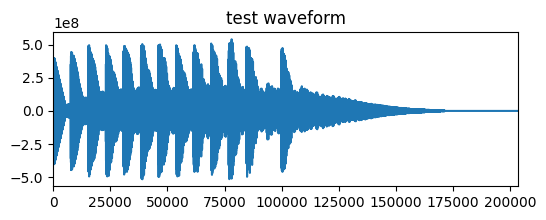

In [32]:
audio = AudioSegment.from_wav("./test.wav")
player(audio, zoom=1, title="test waveform")

# push the play button!

Did you enjoy those smooth notes?

You might be wondering what is that function plot we see below the player. If you already know what it is, a brief refresher doesn't hurt. If it's the first time you delve into this, welcome to the world of **Digital Sound Processing**!! 🕺

A simple way to represent sound is as a **list of samples**. Let's try to zoom into the plot above:

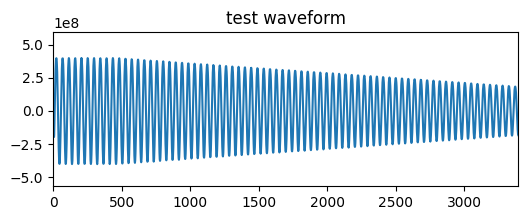

In [33]:
player(audio, zoom=60., title="test waveform")

On the *x*-axis we see time; on the *y*-axis, we have the sample amplitude. Therefore, in the plot above we are looking at a window of roughly $3,500$ samples.

How many samples in time are we using to represent the entire audio file? Let's see:

In [34]:
print(len(audio.get_array_of_samples()))

203520


Wow, that's a lot of samples for just $8$ seconds of sound! If each of these samples was a letter of the alphabet, we would have a book of $150$ pages!

That's because we are representing sound using $24,000$ samples per second; in signal processing we say that the **sample rate** (or **frame rate**) is $24$ kHz.

In [35]:
print(audio.frame_rate)

24000


Sometimes you need to process audio more quickly, or save some memory, hence it can be useful to decrease the sample rate. Let's do this:

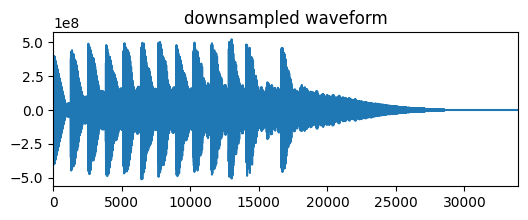

In [37]:
audio_downsampled = audio.set_frame_rate(4000)
player(audio_downsampled, zoom=1., title="downsampled waveform")

The sound quality has decreased, but it sounds acceptable given the 6x times reduction in memory!

Finally, each of the $33,920$ samples of this downsampled soundwave is stored with a certain precision; is it just $1$ byte per sample? $4$ bytes? Are these integer values, or floating point numbers? Are these signed or unsigned numbers?

Let's check:

In [39]:
print(audio.sample_width)

4


The **sample width** is the number of bytes used to represent each sample. As you can imagine, it determines the sound quality. The wider, the merrier!

Let's try to reduce the sample width to just $1$ byte per sample:

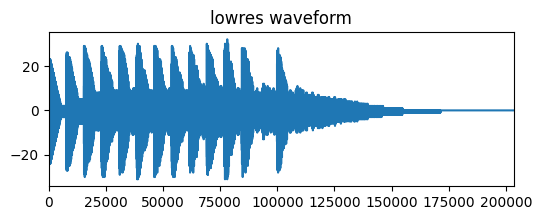

In [41]:
audio_lowres = audio.set_sample_width(1)
player(audio_lowres, zoom=1., title="lowres waveform")

You can still hear what's going on, but there's strong background noise!

To conclude, there is a trade-off between sound quality and efficiency when we deal with digital audio; however, for a ML project, it might be good to reduce quality whenever needed, if it makes things easier to test!

## Spectrograms

## Composing music